<a href="https://colab.research.google.com/github/avner098/Real-time-wildfire-detection-with-deep-learning-using-UNET-YOLO/blob/main/Atenttion_Unet_%26_YOLOv4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from google.colab import drive
import tensorflow as tf
from keras.utils import custom_object_scope
from tensorflow.keras import backend as K
drive.mount('/content/drive')

Mounted at /content/drive


# **Loading models**

In [ ]:
# Load your pre-trained Attention U-Net model

Unet_model_lr6_Epoch_70_mosaic = load_model('/content/drive/My Drive/Final_Project/UnetFiles/Attention_unet_model_lr:1e-6_Epoch_70_mosaic.keras')
Unet_model_lr6_Epoch_40 = load_model('/content/drive/My Drive/Final_Project/UnetFiles/Attention_unet_model_lr:1e-6_Epoch_40.keras')
Unet_model_lr5_Epoch_60 = load_model('/content/drive/My Drive/Final_Project/UnetFiles/Attention_unet_model_lr:1e-5_Epoch_60.keras')
Unet_model_lr4_Epoch_40 = load_model('/content/drive/My Drive/Final_Project/UnetFiles/Attention_unet_model_lr:1e-4_Epoch_40.keras')
# Load YOLO
yolo = cv2.dnn.readNet("/content/drive/MyDrive/Final_Project/yoloFiles/yolov4-obj.weights",
                      "/content/drive/MyDrive/Final_Project/yoloFiles/yolov4-obj.cfg")
with open("/content/drive/MyDrive/Final_Project/yoloFiles/obj.names", "r") as f:
    classes_yolo = [line.strip() for line in f.readlines()]

# **Image and mask processing functions**

In [ ]:


def resize_and_pad(image, size):
        original_shape = tf.shape(image)[:2]
        height = tf.cast(original_shape[0], tf.float32)
        width = tf.cast(original_shape[1], tf.float32)

        if tf.reduce_all(original_shape <= size):
            # If both dimensions are less than or equal to target_size, pad the image
            pad_height = size - original_shape[0]
            pad_width = size - original_shape[1]
            padded_image = tf.image.pad_to_bounding_box(image, pad_height // 2, pad_width // 2, size, size)
        else:
            # Resize while maintaining aspect ratio
            ratio = tf.cast(size, tf.float32) / tf.reduce_max([height, width])
            new_height = tf.cast(height * ratio, tf.int32)
            new_width = tf.cast(width * ratio, tf.int32)
            resized_image = tf.image.resize(image, [new_height, new_width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

            # Pad the resized image
            pad_height = size - new_height
            pad_width = size - new_width
            padded_image = tf.image.pad_to_bounding_box(resized_image, pad_height // 2, pad_width // 2, size, size)

        return padded_image

def resize_conclusion(conclusion, original_shape):

    if not isinstance(conclusion, np.ndarray):
        conclusion = conclusion.numpy()

    target_size = conclusion.shape[0]
    if original_shape[0] <= target_size and original_shape[1] <= target_size:
        # Remove padding to fit original shape
        pad_height = target_size - original_shape[0]
        pad_width = target_size - original_shape[1]
        conclusion = conclusion[pad_height // 2: pad_height // 2 + original_shape[0], pad_width // 2: pad_width // 2 + original_shape[1]]
    else:

        # Resize back to original shape while maintaining the aspect ratio
        conclusion = cv2.resize(conclusion, (original_shape[1], original_shape[0]), interpolation=cv2.INTER_NEAREST)

    return conclusion

def combine_with_original(image, mask):
    # Ensure mask is float before comparison
    mask = tf.cast(mask, tf.float32)

    # Apply threshold to the mask (0.5 threshold)
    mask_thresholded = tf.cast(mask > 0.5, tf.uint8).numpy()

    # Resize the mask to match the original image dimensions
    mask_resized = cv2.resize(mask_thresholded, (image.shape[1], image.shape[0]))

    # Create a blue background image
    combined_image = np.zeros_like(image)
    combined_image[:, :] = [0, 0, 255]  # Set background to blue (BGR format)

    # Apply the mask: where mask is 1, keep the original image
    combined_image[mask_resized == 0] = image[mask_resized == 0]

    return combined_image

def crop_images_from_bboxes(image, bboxes):
    cropped_images = []
    for bbox in bboxes:
        x, y, w, h = bbox
        cropped_image = image[y:y+h, x:x+w]
        cropped_images.append(cropped_image)
    return cropped_images

def paste_images_to_locations(original_image, cropped_images, bboxes):
    result_image = original_image.copy()
    for cropped_image, bbox in zip(cropped_images, bboxes):
        x, y, w, h = bbox
        # Resize cropped image to fit in bounding box
        cropped_resized = cv2.resize(cropped_image, (w, h), interpolation=cv2.INTER_NEAREST)

        # Make sure the dimensions match exactly
        region_to_replace = result_image[y:y+h, x:x+w]

        # Check for height and width mismatches and adjust
        cropped_resized = cropped_resized[:region_to_replace.shape[0], :region_to_replace.shape[1]]

        # Replace the region with the resized image
        result_image[y:y+h, x:x+w] = cropped_resized

    return result_image


# **YOLOv4 detection function**

In [ ]:
def detect_objects(img , net = yolo, classes = classes_yolo, conf_threshold=0.2, nms_threshold=0.3,size = 416):
    # Get the names of all layers in the network
    layer_names = net.getLayerNames()

    # Get the names of the output layers, i.e., the layers responsible for detection
    output_layer_indices = net.getUnconnectedOutLayers()  # Get the indices of the output layers
    output_layers = [layer_names[i - 1] for i in output_layer_indices]  # Adjust for zero-based indexing

    height, width, channels = img.shape

    # Detecting objects
    blob = cv2.dnn.blobFromImage(img, 0.00392, (size, size), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # Showing information on the screen
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > conf_threshold and class_id == 1:

                # Object detected
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    if(len(indexes) == 0):
      return [],[]
    filtered_boxes = [boxes[i] for i in indexes.flatten()]
    filtered_confidences = [confidences[i] for i in indexes.flatten()]


    return filtered_boxes ,filtered_confidences

# **Attention U Net segmentation function**

In [ ]:
def segment_image(image, model=Unet_model_lr6_Epoch_70_mosaic):
    # Resize and pad the input image to the model's expected size (320x320)
    input_image = resize_and_pad(image, 320)

    # Visualize the resized input image
    #plt.imshow(input_image)
    #plt.show()

    # Expand dimensions to add batch size (since model expects batch as the first dimension)
    input_image = np.expand_dims(input_image, axis=0)  # Shape becomes (1, 320, 320, 3)

    # Make prediction using the model
    mask = model.predict(input_image)

    # Remove the batch dimension, so shape becomes (320, 320, num_classes)
    mask = np.squeeze(mask)

    # Create a mask based on the prediction (class with highest probability)
    mask = create_mask(mask)

    # Visualize the segmented mask
    #plt.imshow(tf.keras.utils.array_to_img(mask))
    #plt.show()

    # Resize the mask back to the original image size
    resized_mask = resize_conclusion(mask, image.shape[:2])  # (height, width)

    # Combine the original image with the resized mask
    combined_image = combine_with_original(image, resized_mask)

    return combined_image


def create_mask(pred_mask):
    # Get the class with the highest probability
    pred_mask = tf.argmax(pred_mask, axis=-1)

    # Expand dimensions for proper visualization (height, width, 1)
    pred_mask = pred_mask[..., tf.newaxis]

    # Return the mask for the first image in the batch (batch size = 1)
    return pred_mask


def detect_and_segment(frame,model = Unet_model_lr6_Epoch_70_mosaic):
    # Detect objects in the frame
    bboxes, conf = detect_objects(frame)

    # Crop images from the bounding boxes
    fire_detected = crop_images_from_bboxes(frame, bboxes)

    segment_images = []

    for img in fire_detected:
        # Convert the image from BGR (OpenCV default) to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Perform segmentation on the cropped image
        segmented_img = segment_image(img,model)

        # Append the segmented image to the list
        segment_images.append(segmented_img)

    # Convert the original frame to RGB for visualization
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Paste the segmented images back into their original locations
    result_image = paste_images_to_locations(frame, segment_images, bboxes)

    # Draw bounding boxes around the detected objects
    for i in range(len(bboxes)):
        x, y, w, h = bboxes[i]
        confidence = conf[i]
        color = (255, 0, 0)  # Blue bounding box
        cv2.rectangle(result_image, (x, y), (x + w, y + h), color, 2)

    return result_image


# **Prediction of the models**

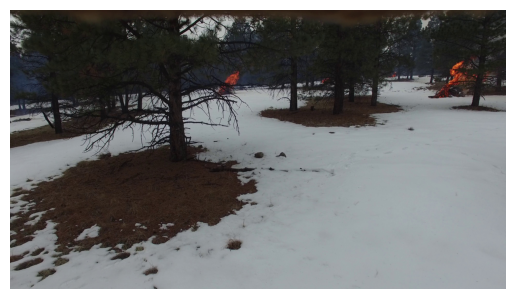

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Time taken for detect_and_segment with model <Functional name=U-Net, built=True>: 13.6816 seconds


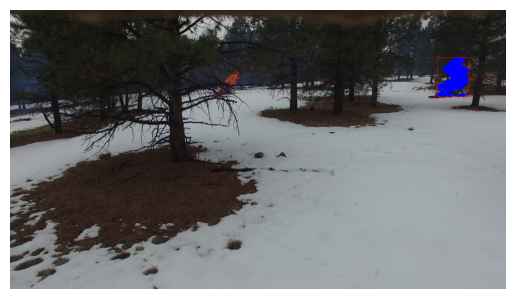

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Time taken for detect_and_segment with model <Functional name=U-Net, built=True>: 3.9586 seconds


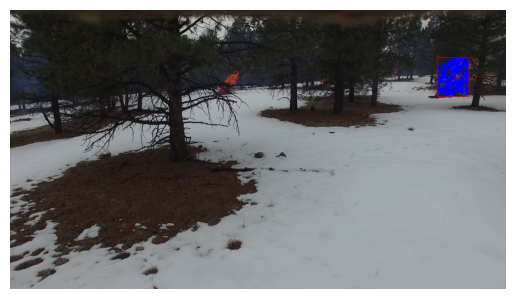

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Time taken for detect_and_segment with model <Functional name=U-Net, built=True>: 6.7976 seconds


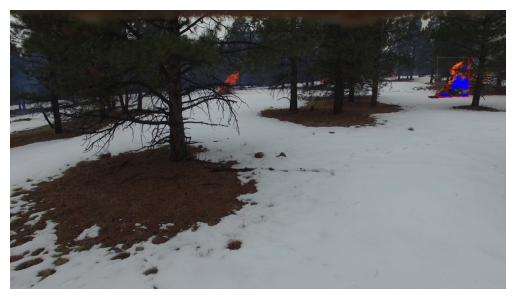

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Time taken for detect_and_segment with model <Functional name=U-Net, built=True>: 3.0934 seconds


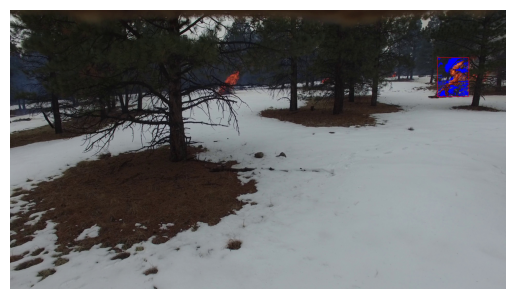

In [ ]:
import time

image_path = '/content/drive/MyDrive/datasetUnet/Images/image_231.jpg'

image = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
# List of models
models = [
    Unet_model_lr6_Epoch_70_mosaic,
    Unet_model_lr6_Epoch_40,
    Unet_model_lr5_Epoch_60,
    Unet_model_lr4_Epoch_40
]

# Detect, segment, and display results for each model
for model in models:
    start_time = time.time()
    res = detect_and_segment(image, model)
    elapsed_time = time.time() - start_time
    print(f'Time taken for detect_and_segment with model {model}: {elapsed_time:.4f} seconds')
    plt.imshow(res)
    plt.axis('off')
    plt.show()
